In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev

In [30]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Thu, 09 Mar 2023 11:28:37] [INFO    ] [topostats] Extracting image from Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm
[Thu, 09 Mar 2023 11:28:37] [INFO    ] [topostats] Loading image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm
[Thu, 09 Mar 2023 11:28:37] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013] : Loaded image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm
[Thu, 09 Mar 2023 11:28:37] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013] : Extracted channel Height
[Thu, 09 Mar 2023 11:28:37] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013] : Pixel to nm scaling : 5.1109375


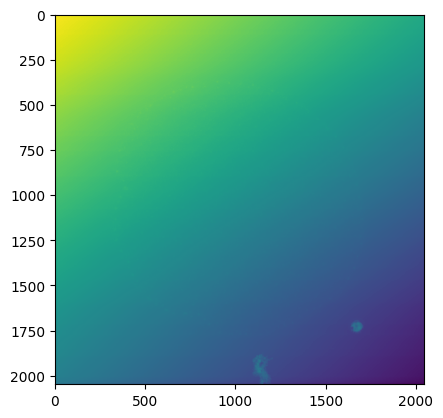

In [31]:
# file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm')
file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm')
# file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [11]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Thu, 09 Mar 2023 11:19:53] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : Median flattening without mask
[Thu, 09 Mar 2023 11:19:54] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : Plane tilt removal without mask
[Thu, 09 Mar 2023 11:19:54] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : x-polyfit 1st order: [-2.95118672e-02  3.00639774e+01]
[Thu, 09 Mar 2023 11:19:54] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : y-polyfit 1st order: [ 1.07143464e-19 -9.32898823e-17]
[Thu, 09 Mar 2023 11:19:54] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : Removing x plane tilt
[Thu, 09 Mar 2023 11:19:55] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : removing y plane tilt
[Thu, 09 Mar 2023 11:19:55] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00013.spm] : Remove quadra

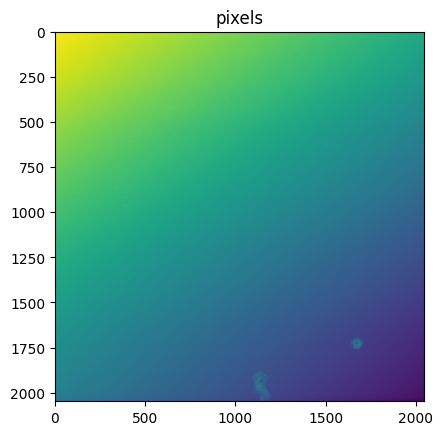

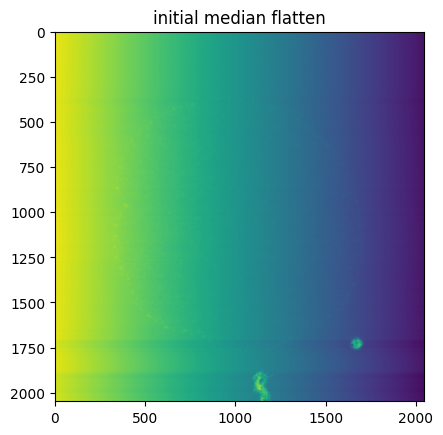

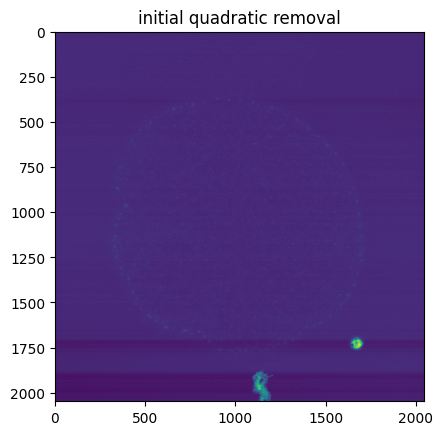

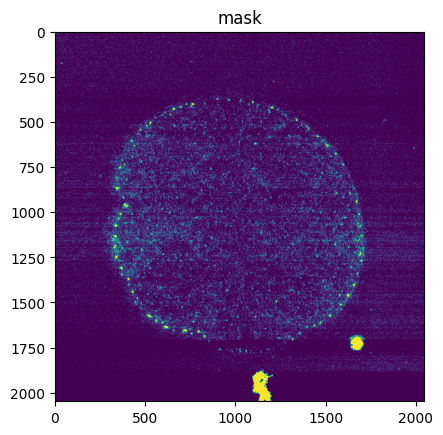

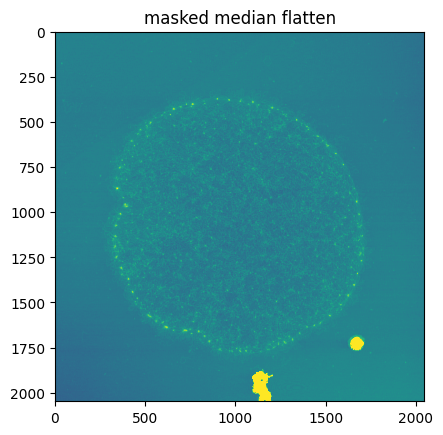

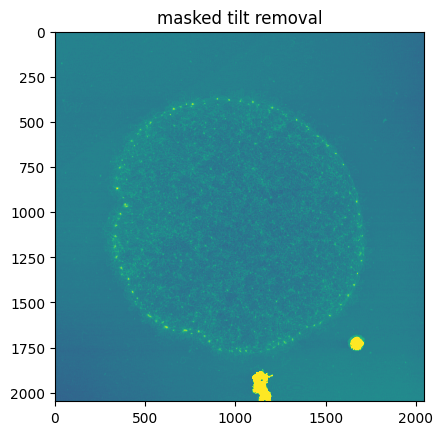

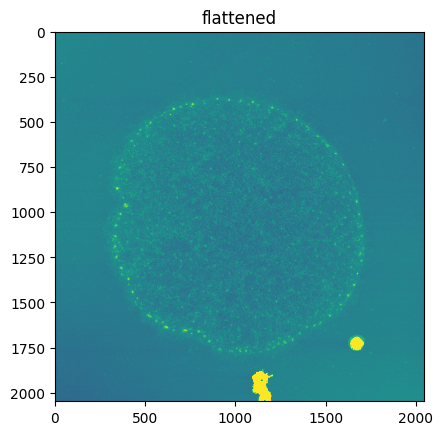

In [12]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 4.1080251042685605})
[Thu, 09 Mar 2023 11:39:27] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 4.1080251042685605


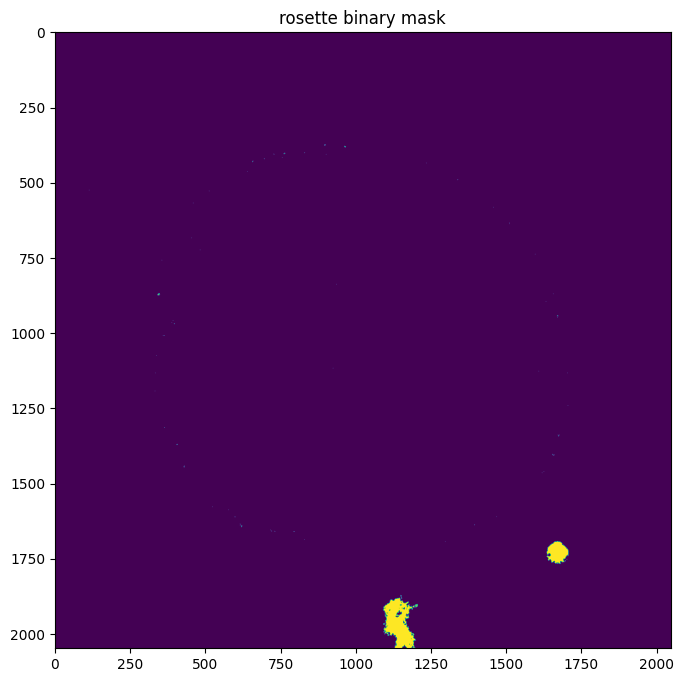

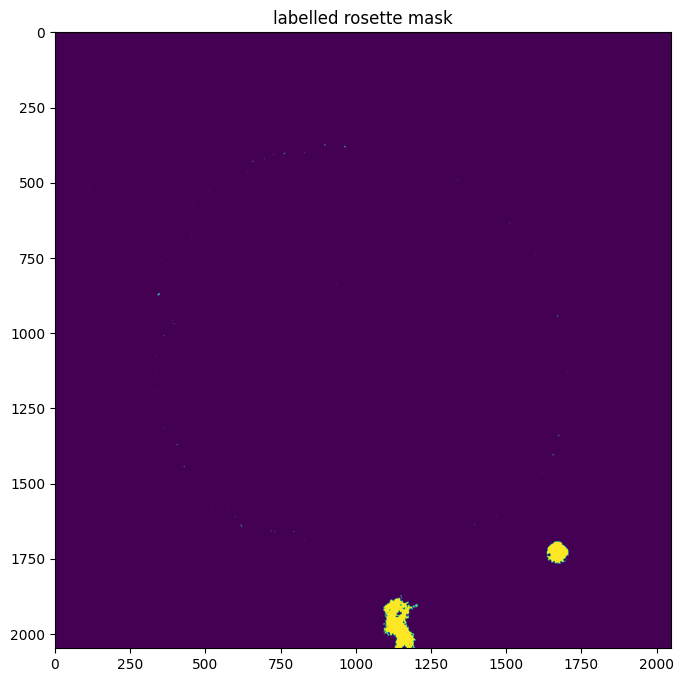

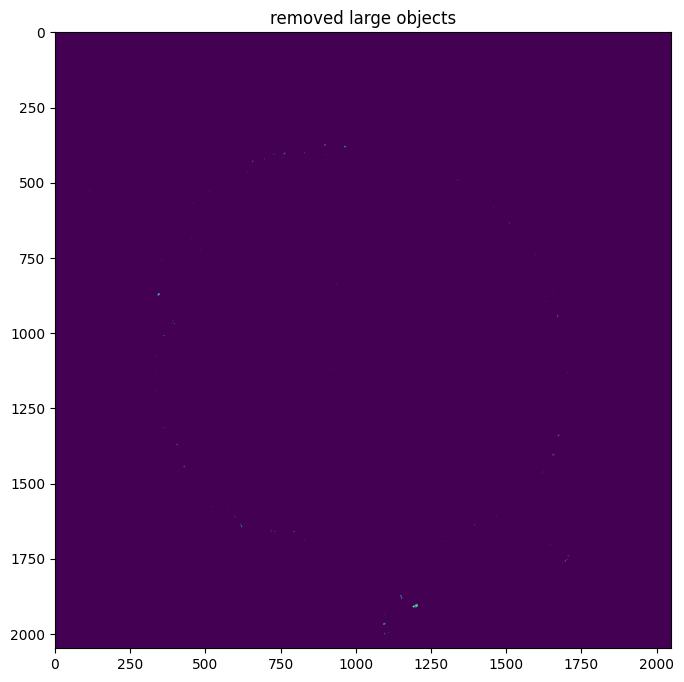

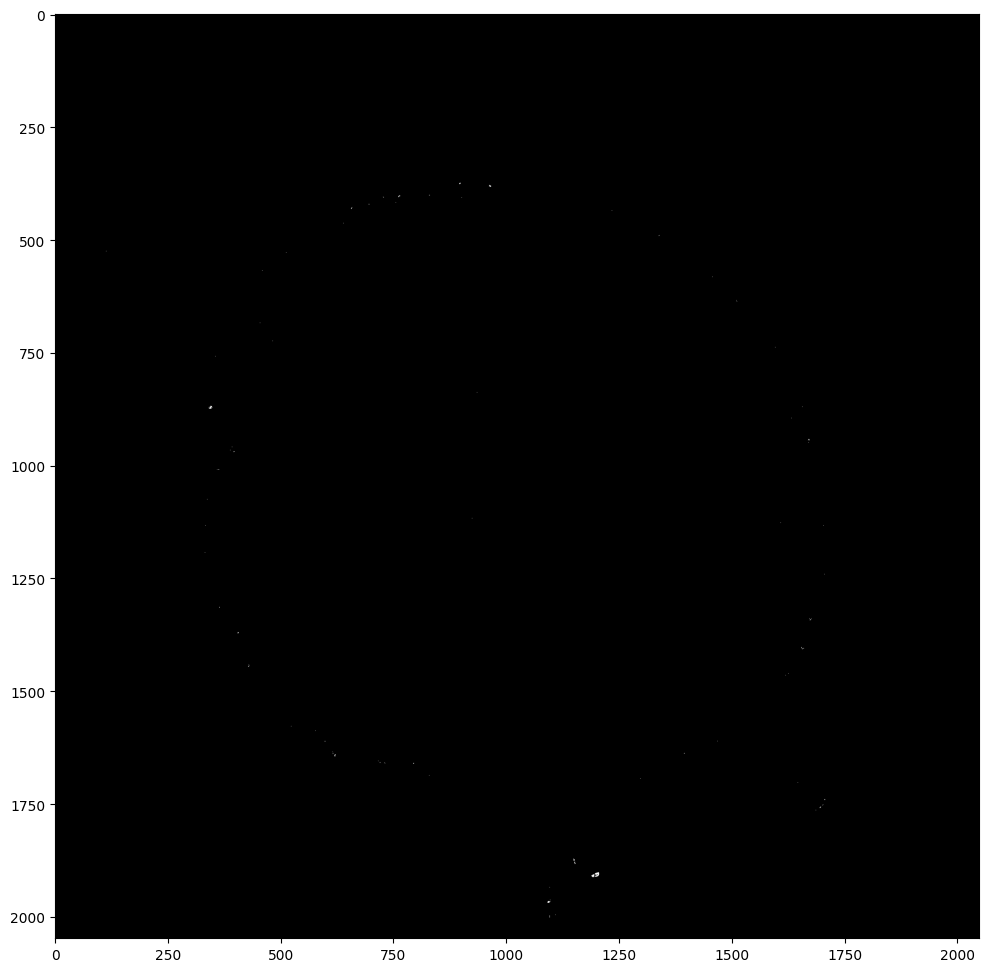

In [53]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 3.5, 'lower': None}
)
# rosette_thresholds = topofilters.get_thresholds(
#     flattened,
#     threshold_method='absolute',
#     threshold_absolute={'upper': 3.75, 'lower': None}
# )
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
# rosette_mask = remove_small_objects(rosette_mask, 25)
# plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(rosette_mask)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 100:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


In [14]:
def ellipse_eqn(params, x, y):
    x0, y0, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = ((x - x0) * cos_theta + (y - y0) * sin_theta) ** 2 / a ** 2
    ellipse_y = ((x - x0) * sin_theta - (y - y0) * cos_theta) ** 2 / b ** 2
    return ellipse_x + ellipse_y - 1

In [15]:
def fit_ellipse(x_data: np.ndarray, y_data: np.ndarray) -> np.ndarray:
    # Guess initial params for ellipse
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    x_range = np.max(x_data) - np.min(x_data)
    y_range = np.max(y_data) - np.min(y_data)
    a_guess = x_range / 2
    b_guess = y_range / 2
    params_guess = [x_mean, y_mean, a_guess, b_guess, 0]
    # Numerically find best fitting ellipse
    result = least_squares(ellipse_eqn, params_guess, args=(x_data, y_data))

    # x0, y0, a, b, theta = params
    return result.x

In [16]:
from skimage.measure import label, regionprops
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid
    y_data = points[:, 0]
    x_data = points[:, 1]

    return (y_data, x_data)

y_data, x_data = get_points(rosette_mask)

In [17]:
def fit_ellipse_remove_far_points(binary_image: np.ndarray, dist_stddev_thresh_multiplier: float) -> np.ndarray:
    y_data, x_data = get_points(binary_image)

    params = fit_ellipse(x_data, y_data)

    # Plot ellipse
    x0, y0, a, b, theta = params
    t = np.linspace(0, 2 * np.pi, 100)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
    ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
    fig_fit, ax_fit = plt.subplots(1, 2, figsize=(10, 5))
    ax_fit[0].scatter(x_data, y_data)
    ax_fit[0].plot(ellipse_x, ellipse_y)
    ax_fit[0].axis('equal')
    ax_fit[0].set_aspect(1)
    ax_fit[0].invert_yaxis()
    ax_fit[0].set_title('fitted ellipse')

    # Get distances of points from ellipse
    distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])
    dist_thresh = np.mean(distances) + dist_stddev_thresh_multiplier * np.std(distances)
    # Initialise image comparison plots
    fig_img, ax_img = plt.subplots(1, 3, figsize=(14, 5))

    # Plot residuals
    ax_fit[1].scatter(x_data, distances)
    ax_fit[1].set_xlim(0, 2000)
    ax_fit[1].axhline(y=dist_thresh, color='r', linestyle='-')
    ax_fit[1].axhline(y=-dist_thresh, color='r', linestyle='-')
    ax_fit[1].set_title('residuals')

    # Remove points too far from ellipse
    too_far_indicies = np.where(abs(distances) > dist_thresh)[0]
    too_far_indicies = np.add(too_far_indicies, 1) # Add one since the label indices start from one
    print(f'too far points: {too_far_indicies}')
    # Copy arrays for posterity
    removed_too_far_points = label(binary_image.copy())
    before_removal = removed_too_far_points.copy()
    # Remove too far points
    for index in too_far_indicies:
        removed_too_far_points[removed_too_far_points==index] = 0
        circle = plt.Circle((x_data[index-1], y_data[index-1]), 50, fill=False)
        ax_img[0].add_artist(circle)
        ax_fit[1].scatter(x_data[index-1], distances[index-1], marker='.', color='r') # Sub one since point indices start from zero
        ax_fit[0].scatter(x_data[index-1], y_data[index-1], marker='.', color='r')

    # Plot results
    ax_img[0].imshow(before_removal.astype(bool))
    ax_img[0].set_title('before')
    ax_img[1].imshow(removed_too_far_points.astype(bool))
    ax_img[1].set_title('removed too far points')
    ax_img[2].imshow((removed_too_far_points - before_removal).astype(bool))
    ax_img[2].set_title('difference')
    fig_img.suptitle(f'thresh={dist_stddev_thresh_multiplier}*std_dev + mean')
    fig_img.tight_layout()
    plt.show()

    return removed_too_far_points

too far points: [31 65]


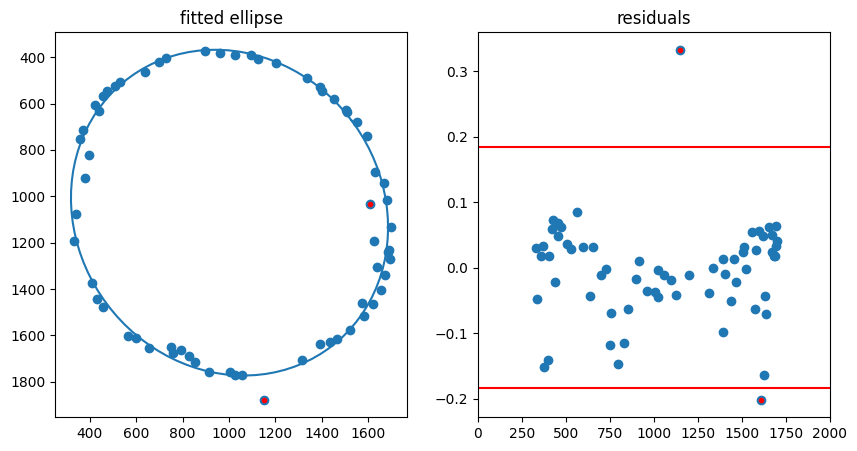

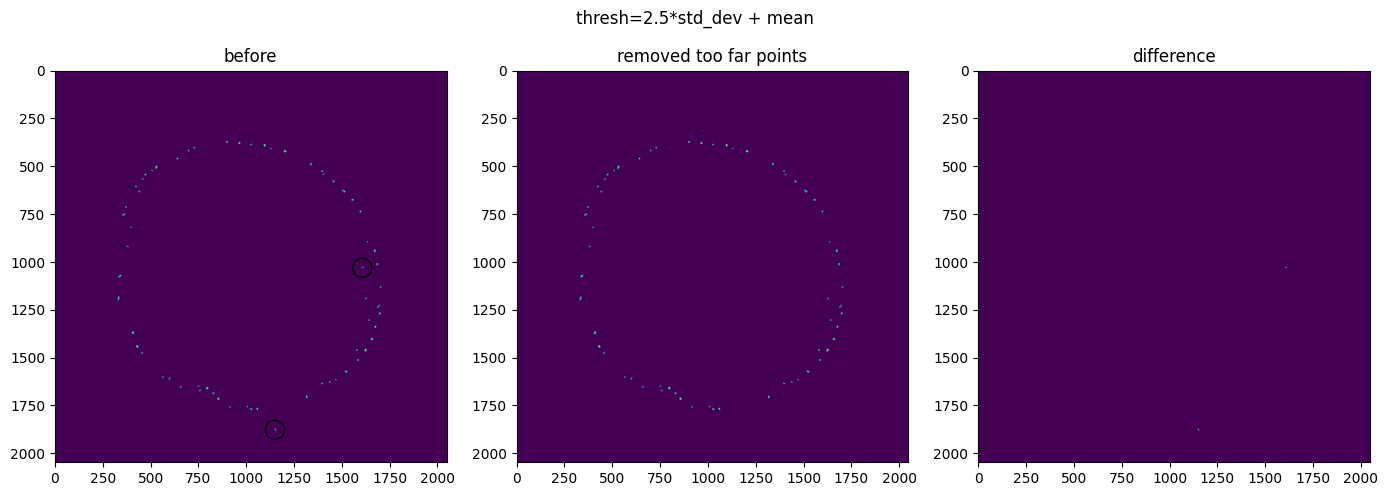

too far points: [26 28 34 55]


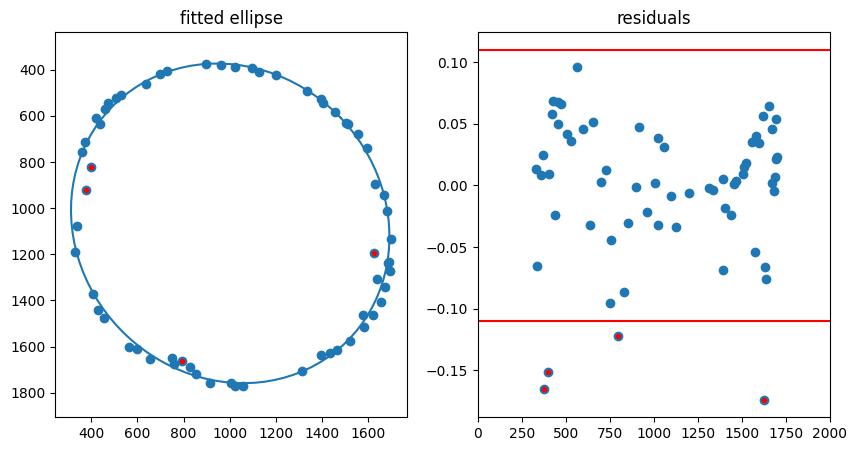

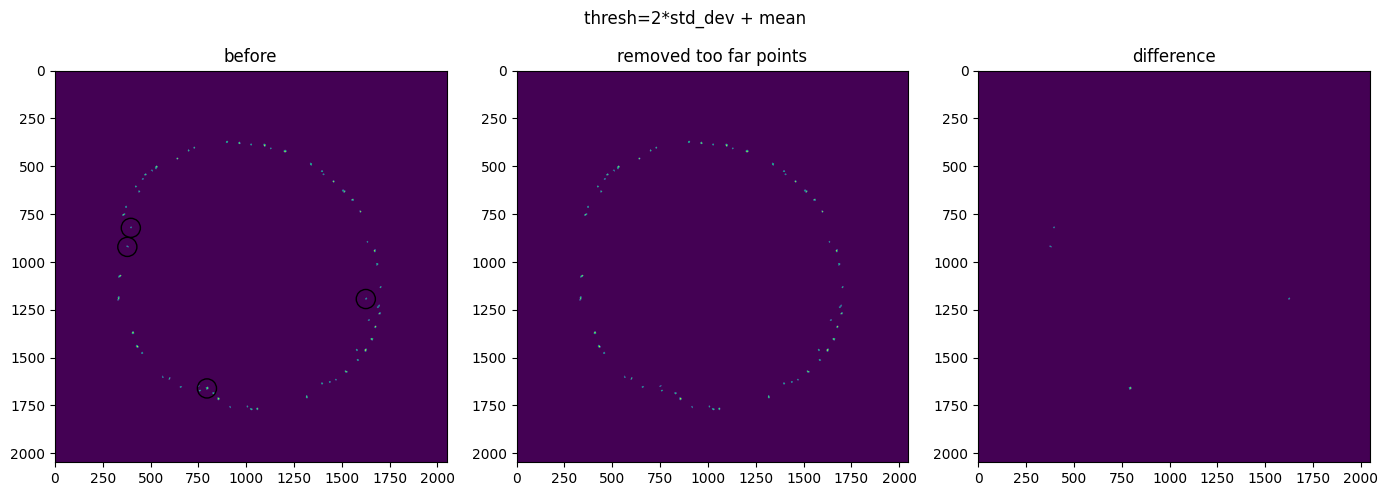

too far points: [26 29 35 41 45 49 50 53]


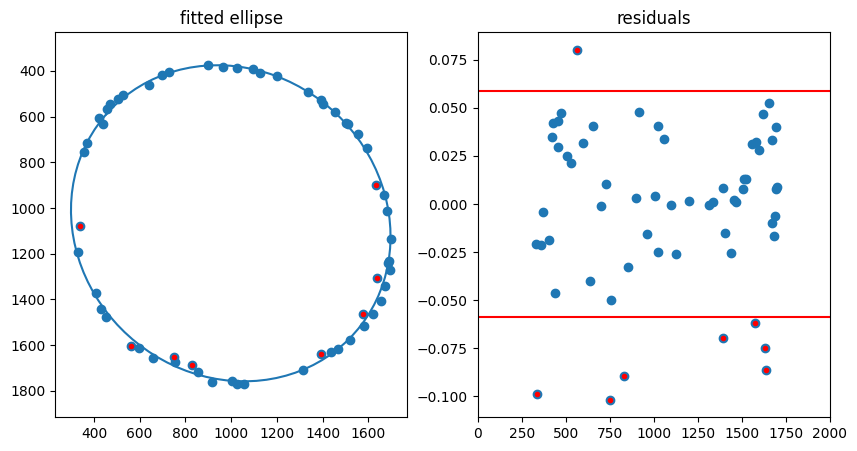

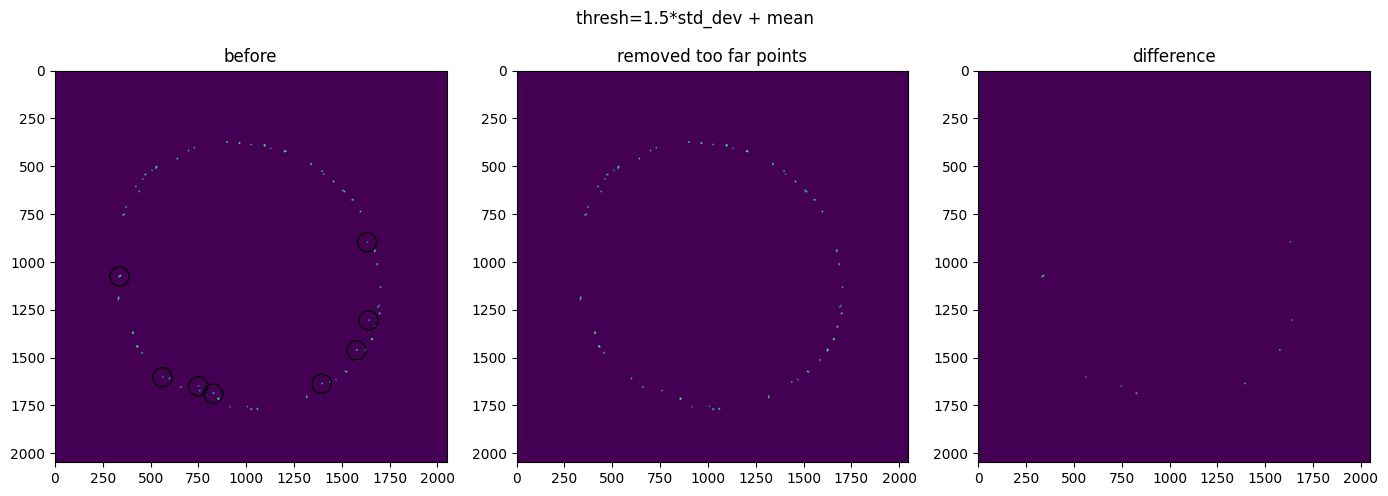

In [18]:
fitted_1 = fit_ellipse_remove_far_points(binary_image=labelled_rosette_mask, dist_stddev_thresh_multiplier=2.5)
fitted_2 = fit_ellipse_remove_far_points(binary_image=fitted_1, dist_stddev_thresh_multiplier=2)
fitted_3 = fit_ellipse_remove_far_points(binary_image=fitted_2, dist_stddev_thresh_multiplier=1.5)

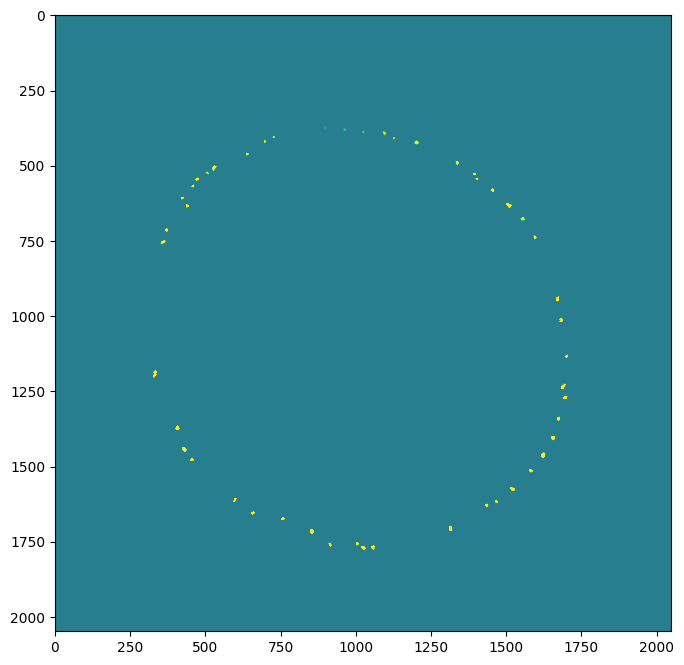

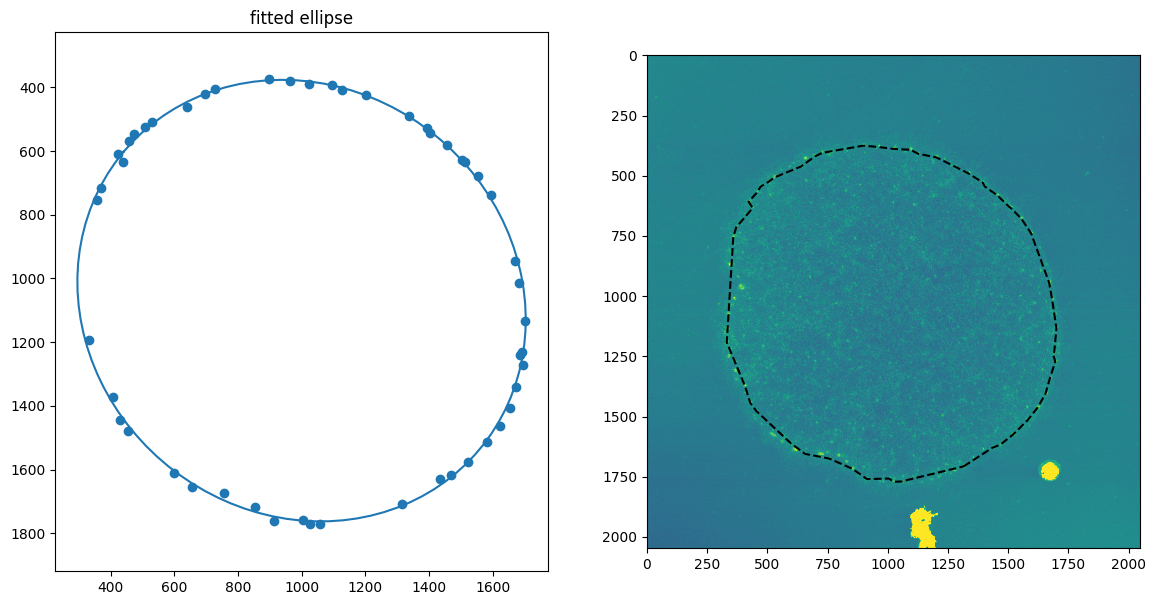

In [54]:
# Find the points in order
plot(fitted_3)

labelled = label(fitted_3)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid
y_data = points[:, 0]
x_data = points[:, 1]

params = fit_ellipse(x_data, y_data)
ellipse_distances = np.array([ellipse_eqn(params, x_val, y_val) for x_val, y_val in zip(x_data, y_data)])

# Plot ellipse
x0, y0, a, b, theta = params
t = np.linspace(0, 2 * np.pi, 100)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta
fig_fit, ax_fit = plt.subplots(1, 2, figsize=(14, 7))
ax_fit[0].scatter(x_data, y_data)
ax_fit[0].plot(ellipse_x, ellipse_y)
ax_fit[0].axis('equal')
ax_fit[0].set_aspect(1)
ax_fit[0].invert_yaxis()
ax_fit[0].set_title('fitted ellipse')

# Calculate the centroid of the points
centroid = np.mean(points, axis=0)

# Function to find angle of point from centroid
def angle(point):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point) for point in points])]

# Plot the points
# ax_fit[1].scatter(sorted[:, 1], sorted[:, 0])

# # Draw text next to each point with its position in the array
# for i, point in enumerate(points):
#     ax.text(point[0] + 0.02, point[1] + 0.02, str(i), fontsize=12)

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

ax_fit[1].imshow(flattened, vmin=-3, vmax=4)
ax_fit[1].plot(xs, ys, 'k--')

plt.show()

# ordered_points = []
# visited_indices = []
# point_protection = 10
# iterations = 200

# # Set initial index to that of the point with least distance to the ellipse
# current_index = np.argmin(np.abs(ellipse_distances))
# initial_index = current_index

# ax_fit[0].scatter(points[current_index, 1], points[current_index, 0], color='k', marker='.')

# while (current_index != initial_index) and iterations < 200:
#     # Get current point
#     current_point = points[current_index]
#     # Add to ordered points
#     ordered_points.append(current_point)
#     # Calculate distances and set visited points to infinite
#     distances = np.linalg.norm(points - current_point, axis=1)
#     distances[visited_indices] = np.inf

#     nearest_point_index = np.argmin(distances)
#     current_index = nearest_point_index

# if iterations == 200:
#     print('DID NOT FIND ORIGINAL POINT')


# Spline fitting

[12 13]


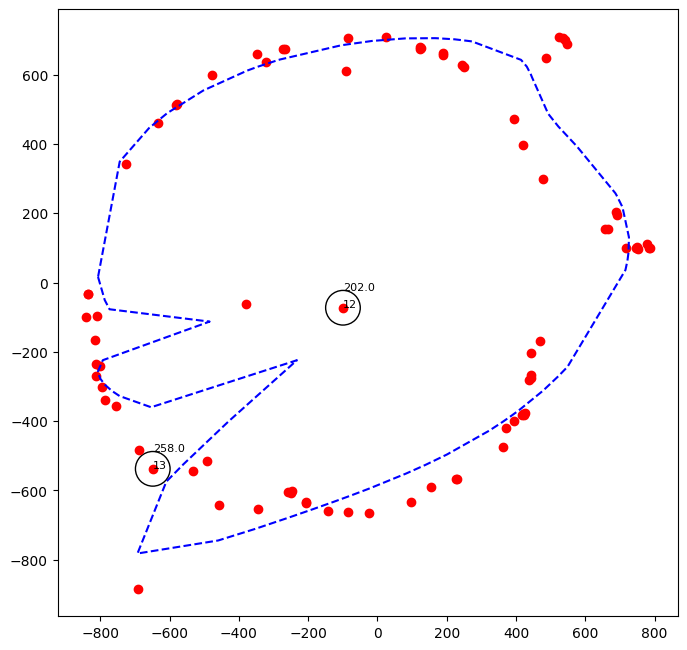

[12 13]
point: [-99.41475453 -72.75894827]
point plus mean: [1117.  924.]
original index 34
1117.0 924.0
point: [-648.41475453 -537.75894827]
point plus mean: [568. 459.]
original index 14
568.0 459.0


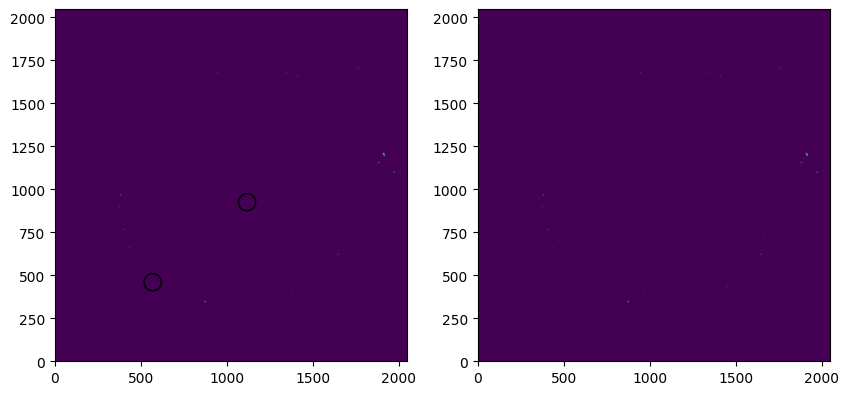

[11 58 69]


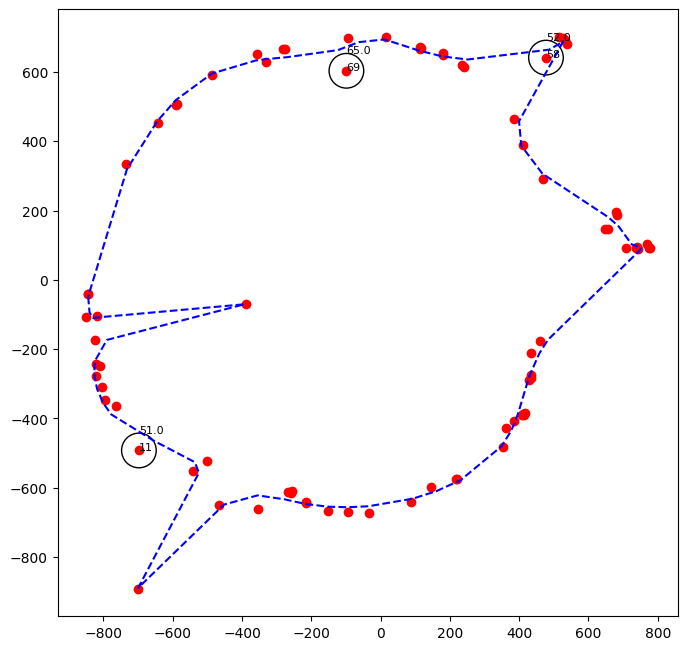

[11 58 69]
point: [-697.76262339 -492.39042198]
point plus mean: [528. 512.]
original index 13
528.0 512.0
point: [477.23737661 641.60957802]
point plus mean: [1703. 1646.]
original index 64
1703.0 1646.0
point: [-98.76262339 603.60957802]
point plus mean: [1127. 1608.]
original index 33
1127.0 1608.0


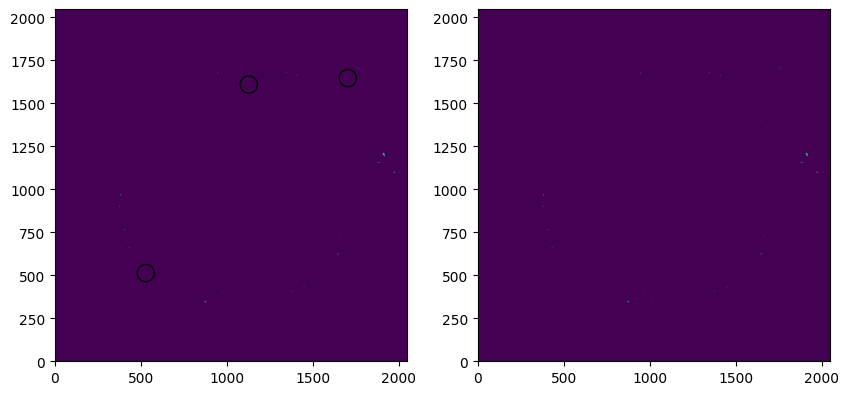

[]


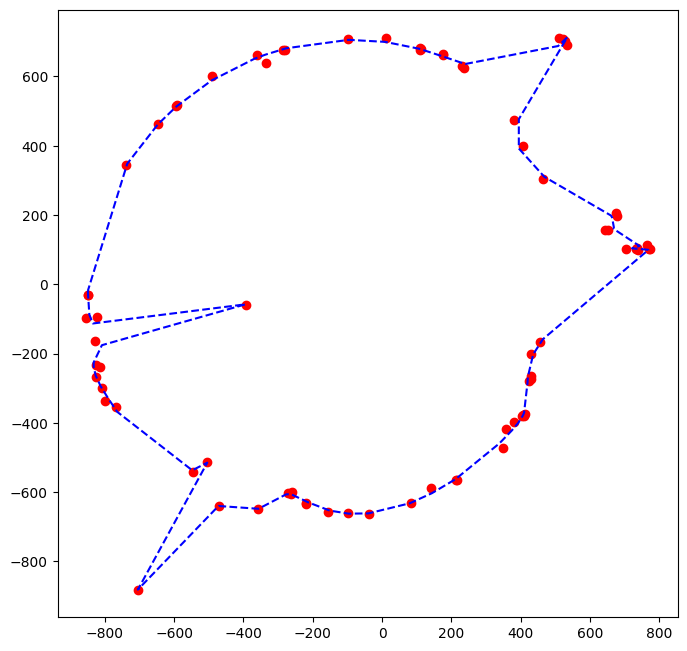

[]


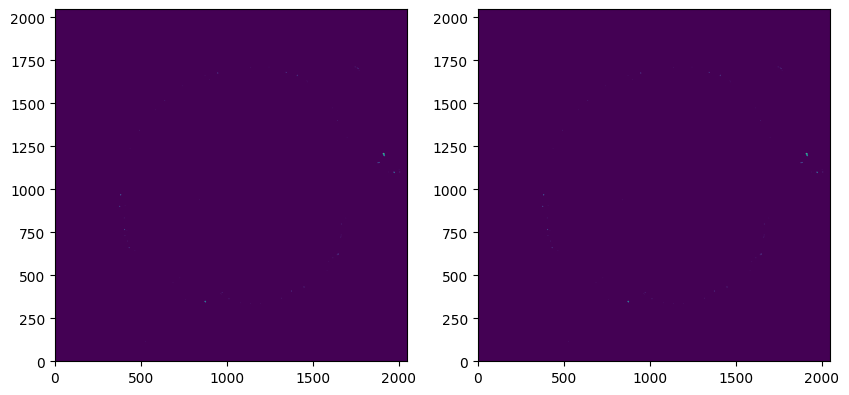

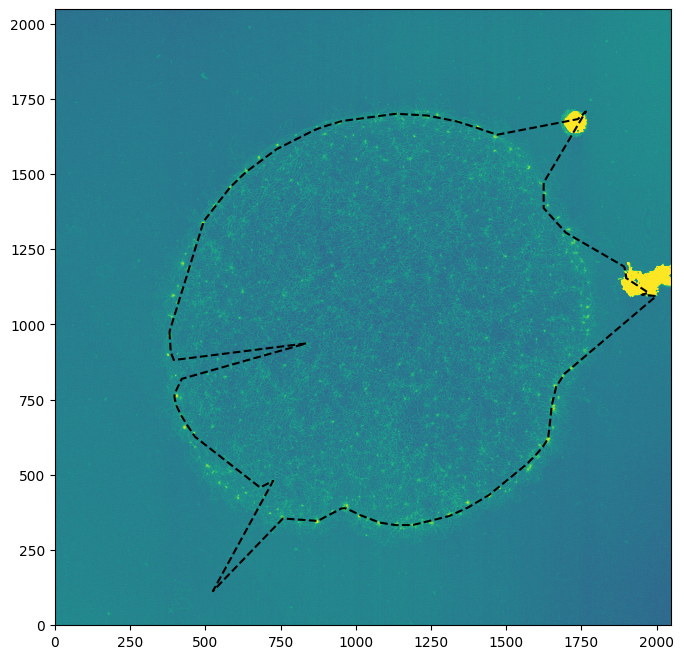

In [60]:
def fit_spline_and_remove_outliers(binary_image: np.ndarray, dist_stddev_thresh_multiplier: float, smoothing: int) -> np.ndarray:

    labelled = label(binary_image)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid
    x = points

    # SORTING METHOD 1
    # # Function to find angle of point from centroid
    # def angle(point):
    #     dx, dy = point - centroid
    #     return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)
    # # Sort the points based on their angles around the centroid
    # sorted = points[np.argsort([angle(point) for point in points])]

    # SORTING METHOD 2
    # # Sort the points
    # Mean position
    mean_position = x.mean(0)
    xs = (x - mean_position)
    sorted = xs[np.angle((xs[:,0] + 1j*xs[:,1])).argsort()]

    # Fit spline to the data
    def fit_spline(ordered_points: np.ndarray, smoothing: int):
        tck, u = splprep(sorted.T, u=None, s=smoothing, per=1) 
        # u_new = np.linspace(u.min(), u.max(), len(ordered_points))
        # x_new, y_new = splev(u_new, tck, der=0)

        # # Evaluate the spline at a set of points
        fit_points = splev(u, tck)
        
        return fit_points[0], fit_points[1]

    x_fit, y_fit = fit_spline(ordered_points=sorted, smoothing=smoothing)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(sorted[:,0], sorted[:,1], 'ro')
    ax.plot(x_fit, y_fit, 'b--');

    # Calculate the distance between each point and its corresponding spline point
    distances = np.sqrt((sorted[:, 0] - x_fit)**2 + (sorted[:, 1] - y_fit)**2)

    # Find the index of the point with the maximum distance
    too_far_indicies = np.where(distances > np.mean(distances) + np.std(distances) * dist_stddev_thresh_multiplier)[0]

    # Print the point with the maximum distance
    print(too_far_indicies)

    for index in too_far_indicies:
        circle = plt.Circle((sorted[index, 0], sorted[index, 1]), 50, fill=False)
        ax.text(sorted[index, 0], sorted[index, 1], f'{index}', fontsize=8)
        ax.text(sorted[index, 0], sorted[index, 1]+50, f'{np.round(distances[index])}', fontsize=8)
        ax.add_artist(circle)

    ax.set_aspect(1)
    plt.show()


    # NEED TO FIND MAPPING BETWEEN SORTED AND ORIGINAL INDEXES

    # Remove too far points
    fig_img, ax_img = plt.subplots(1, 2, figsize=(10, 5))
    ax_img[0].imshow(binary_image.astype(bool).T)
    removed_too_far_points = label(binary_image.copy())
    before_removal = removed_too_far_points.copy()
    # too_far_indicies = np.add(too_far_indicies, 1) # Add to avoid zero problem
    print(too_far_indicies)
    for index in too_far_indicies:
        print(f'point: {sorted[index]}')
        point_plus_mean = sorted[index] + mean_position
        print(f'point plus mean: {point_plus_mean}')
        original_index = np.where(points == sorted[index] + mean_position)[0][0]
        print(f'original index {original_index}')
        removed_too_far_points[removed_too_far_points==original_index+1] = 0

        print(points[original_index, 0], points[original_index, 1])
        circle = plt.Circle((point_plus_mean[0], point_plus_mean[1]), 50, fill=False)
        ax_img[0].add_artist(circle)
        # ax_fit[1].scatter(x_data[index-1], distances[index-1], marker='.', color='r') # Sub one since point indices start from zero
        # ax_fit[0].scatter(x_data[index-1], y_data[index-1], marker='.', color='r')
    ax_img[1].imshow(removed_too_far_points.astype(bool).T)
    ax_img[1].invert_yaxis()
    ax_img[0].invert_yaxis()

    plt.show()

    return removed_too_far_points, x_fit + mean_position[0], y_fit + mean_position[1]


fit_1, _, _ = fit_spline_and_remove_outliers(labelled_rosette_mask.copy(), dist_stddev_thresh_multiplier=2.5, smoothing=500000)
fit_2, _, _ = fit_spline_and_remove_outliers(fit_1, dist_stddev_thresh_multiplier=2.5, smoothing=40000)
fit_3, x_fit, y_fit = fit_spline_and_remove_outliers(fit_2, dist_stddev_thresh_multiplier=2.5, smoothing=10000)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(flattened.T, vmin=-3, vmax=4)
ax.invert_yaxis()
ax.plot(x_fit, y_fit, 'k--')


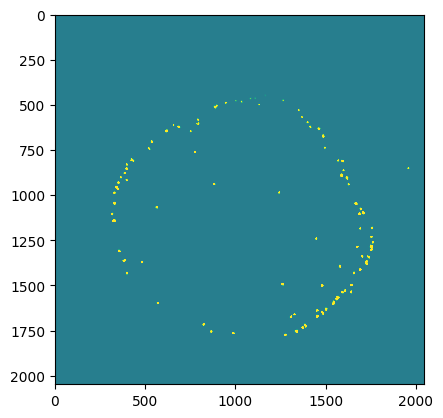

outliers: [84 85 87 88 89]


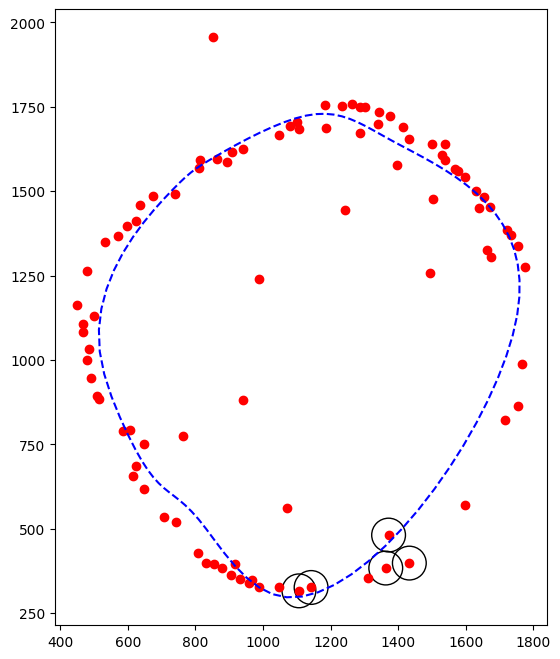

In [428]:
plot(labelled_rosette_mask)
fit_spline_and_remove_outliers(labelled_rosette_mask, dist_stddev_thresh_multiplier=2.0)
